In [17]:
import numpy as np
import pandas as pd
import math
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_excel('CBA.AX5y.xls')

In [19]:
df.columns = df.columns.str.lower()

In [20]:
df = df.drop(labels = ['open', 'high', 'low', 'adj close', 'volume'], axis=1)

In [21]:
df

,date,close
0,2017-09-21,76.070000
1,2017-09-22,76.620003
2,2017-09-25,75.809998
3,2017-09-26,75.099998
4,2017-09-27,74.849998
...,...,...
1262,2022-09-15,95.059998
1263,2022-09-16,94.230003
1264,2022-09-19,94.660004
1265,2022-09-20,96.529999


In [25]:
df['date']

0      2017-09-21
1      2017-09-22
2      2017-09-25
3      2017-09-26
4      2017-09-27
          ...    
1262   2022-09-15
1263   2022-09-16
1264   2022-09-19
1265   2022-09-20
1266   2022-09-21
Name: date, Length: 1267, dtype: datetime64[ns]

In [26]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('2017-09-21')
datetime_object

datetime.datetime(2017, 9, 21, 0, 0)

In [ ]:
df.index = df.pop('date')

In [31]:
df

,close
date,
2017-09-21,76.070000
2017-09-22,76.620003
2017-09-25,75.809998
2017-09-26,75.099998
2017-09-27,74.849998
...,...
2022-09-15,95.059998
2022-09-16,94.230003
2022-09-19,94.660004


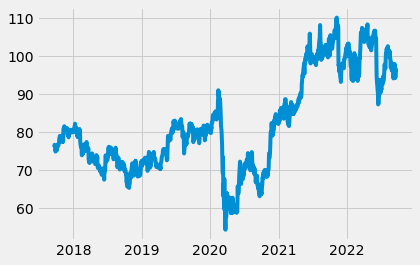

In [32]:
plt.plot(df.index, df['close'])

In [33]:
df.tail()

,close
date,
2022-09-15,95.059998
2022-09-16,94.230003
2022-09-19,94.660004
2022-09-20,96.529999
2022-09-21,95.860001


### Converting data to Supervised learning problem

In [34]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [35]:
datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [38]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df


In [40]:
# Start day second time around 
windowed_df = df_to_windowed_df(df, 
                                '2017-09-26', 
                                '2022-09-21', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2017-09-26,76.070000,76.620003,75.809998,75.099998
1,2017-09-27,76.620003,75.809998,75.099998,74.849998
2,2017-09-28,75.809998,75.099998,74.849998,75.120003
3,2017-09-29,75.099998,74.849998,75.120003,75.250000
4,2017-10-02,74.849998,75.120003,75.250000,76.339996
...,...,...,...,...,...
1259,2022-09-15,96.279999,97.940002,94.459999,95.059998
1260,2022-09-16,97.940002,94.459999,95.059998,94.230003
1261,2022-09-19,94.459999,95.059998,94.230003,94.660004
1262,2022-09-20,95.059998,94.230003,94.660004,96.529999


### Convert data to numpy array

In [41]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # Using 1 for Univariate forecasting

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1264,), (1264, 3, 1), (1264,))

### Split data into Train and Test

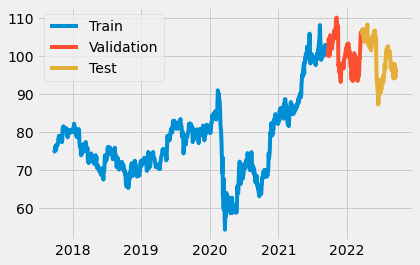

In [42]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

2022-09-23 07:23:32.670772: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
32/32 [==============================] - 3s 23ms/step - loss: 6022.2012 - mean_absolute_error: 76.9702 - val_loss: 9633.2197 - val_mean_absolute_error: 98.0484
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 5135.7495 - mean_absolute_error: 70.8870 - val_loss: 7390.0415 - val_mean_absolute_error: 85.8472
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 2335.9731 - mean_absolute_error: 45.8951 - val_loss: 2082.5713 - val_mean_absolute_error: 45.3979
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 174.4686 - mean_absolute_error: 10.4277 - val_loss: 413.1477 - val_mean_absolute_error: 19.8342
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 99.5523 - mean_absolute_error: 7.6485 - val_loss: 568.7141 - val_mean_absolute_error: 23.4411
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 88.0092 - mean_absolute_error: 7.1606 - val_loss: 471.1186 - val_mean_absolut

Epoch 51/100
32/32 [==============================] - 0s 6ms/step - loss: 1.5843 - mean_absolute_error: 0.9177 - val_loss: 3.5747 - val_mean_absolute_error: 1.4770
Epoch 52/100
32/32 [==============================] - 0s 6ms/step - loss: 1.3653 - mean_absolute_error: 0.8413 - val_loss: 3.4313 - val_mean_absolute_error: 1.4366
Epoch 53/100
32/32 [==============================] - 0s 5ms/step - loss: 1.2718 - mean_absolute_error: 0.7869 - val_loss: 3.4719 - val_mean_absolute_error: 1.4323
Epoch 54/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3499 - mean_absolute_error: 0.8284 - val_loss: 3.3328 - val_mean_absolute_error: 1.4090
Epoch 55/100
32/32 [==============================] - 0s 5ms/step - loss: 1.3152 - mean_absolute_error: 0.8156 - val_loss: 3.2592 - val_mean_absolute_error: 1.4178
Epoch 56/100
32/32 [==============================] - 0s 5ms/step - loss: 1.4690 - mean_absolute_error: 0.8720 - val_loss: 3.7965 - val_mean_absolute_error: 1.6031
Epoch 57/100
32/

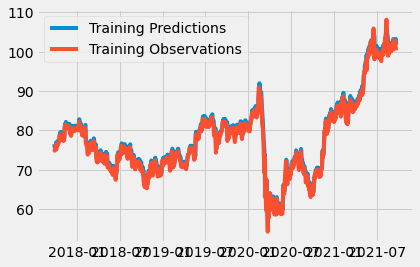

In [44]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

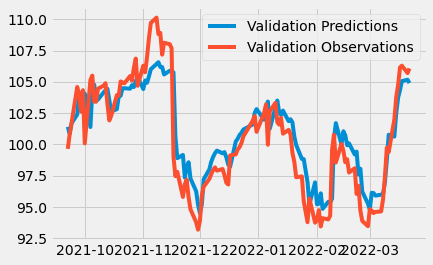

In [45]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

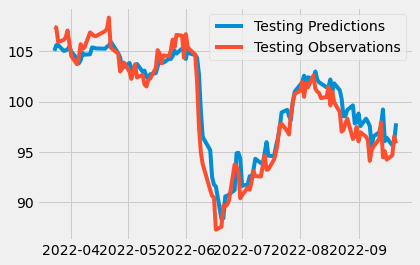

In [46]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

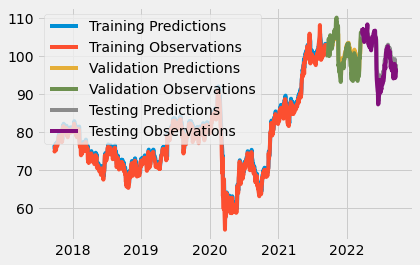

In [47]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

### Recursive prediction using training data to predict val and test dates

In [48]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

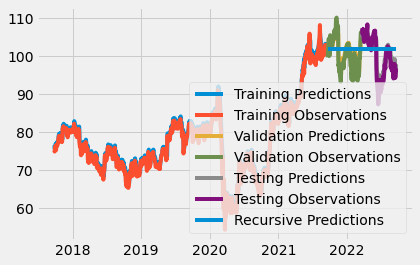

In [49]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])

In [ ]:
#